In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math as mt
import statistics as st

# machine learning models
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# sklearn pacakages for data manipulation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# import competition data
train_data = pd.read_csv("/kaggle/input/playground-series-s3e22/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s3e22/test.csv")
train_data.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [2]:
# combine test and train
combi = pd.concat([train_data, test_data]).copy()

# describe data
print("The length of train_data is",len(train_data["id"]))
print("The length of test_data is",len(test_data["id"]))

print("\ntrain_data object columns:")
train_data.describe(include = object)

The length of train_data is 1235
The length of test_data is 824

train_data object columns:


,surgery,age,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data,outcome
count,1235,1235,1196,1175,1214,1229,1191,1215,1212,1155,1214,1045,1022,1187,1235,1235,1235
unique,2,2,4,4,6,3,6,5,4,3,4,5,5,3,2,2,3
top,yes,adult,cool,reduced,pale_pink,less_3_sec,depressed,hypomotile,moderate,slight,more_1_liter,absent,distend_small,serosanguious,yes,yes,lived
freq,887,1160,700,724,284,834,429,664,543,758,604,493,482,570,929,668,574


In [3]:
print("train_data numeric columns: ")
train_data.describe(include=np.number)

train_data numeric columns: 


,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1235.0000,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,617.0000,9.545004e+05,38.202186,79.574089,30.054251,4.382591,49.602429,21.388016,3.290931,3832.496356,14.612146,3.577328
std,356.6581,1.356403e+06,0.788668,29.108638,16.452066,1.937357,10.535800,26.676453,1.589195,5436.733774,193.705735,88.858953
min,0.0000,5.213990e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.500000,0.100000,0.000000,0.000000,0.000000
25%,308.5000,5.288000e+05,37.800000,53.000000,18.000000,2.000000,43.000000,6.600000,2.000000,2205.000000,0.000000,0.000000
50%,617.0000,5.297770e+05,38.200000,76.000000,28.000000,4.500000,48.000000,7.500000,3.000000,2209.000000,0.000000,0.000000
75%,925.5000,5.341450e+05,38.600000,100.000000,36.000000,6.000000,57.000000,9.100000,4.300000,3205.000000,0.000000,0.000000
max,1234.0000,5.305129e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,3112.000000,2209.000000


In [4]:
print("Unique values in 'capillary':",set(x for x in combi['capillary_refill_time']))
print("\nUnique values in 'peristalsis':\n",set(train_data["peristalsis"]),"\n",set(test_data['peristalsis']))
print("\nUnique values in 'nasogastric_reflux':\n",set(train_data["nasogastric_reflux"]),"\n",set(test_data['nasogastric_reflux']))
print("\nUnique values in 'rectal_exam_feces':\n",set(train_data["rectal_exam_feces"]),"\n",set(test_data['rectal_exam_feces']))
print("\nDescription of 'outcome':")
print(combi["outcome"].describe())
print("There are",sum(pd.isnull(combi["outcome"])),"missing values in 'outcome'.")
print("Unique values in 'outcome':",set(combi["outcome"]))

Unique values in 'capillary': {'less_3_sec', '3', 'more_3_sec', nan}

Unique values in 'peristalsis':
 {nan, 'normal', 'absent', 'hypermotile', 'distend_small', 'hypomotile'} 
 {nan, 'normal', 'absent', 'hypermotile', 'hypomotile'}

Unique values in 'nasogastric_reflux':
 {nan, 'more_1_liter', 'slight', 'less_1_liter', 'none'} 
 {'more_1_liter', nan, 'less_1_liter', 'none'}

Unique values in 'rectal_exam_feces':
 {nan, 'decreased', 'increased', 'serosanguious', 'normal', 'absent'} 
 {nan, 'decreased', 'increased', 'normal', 'absent'}

Description of 'outcome':
count      1235
unique        3
top       lived
freq        574
Name: outcome, dtype: object
There are 824 missing values in 'outcome'.
Unique values in 'outcome': {nan, 'lived', 'euthanized', 'died'}


In [5]:
print("Summary of combi:")
data = pd.DataFrame({"colname":[],"missing":[],"uniques":[]})
for col in combi.columns:
    data.loc[len(data.index)] = [col,
                                 sum(pd.isnull(x) for x in combi[col]),
                                 len(set(x for x in combi[col]))]

display(data)
combi.describe()

Summary of combi:


,colname,missing,uniques
0,id,0,2059
1,surgery,0,2
2,age,0,2
3,hospital_number,0,271
4,rectal_temp,0,43
5,pulse,0,51
6,respiratory_rate,0,42
7,temp_of_extremities,74,5
8,peripheral_pulse,107,5
9,mucous_membrane,34,7


,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,2059.000000,2.059000e+03,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.00000,2059.000000,2059.000000,2059.000000,2059.000000
mean,1029.000000,1.016073e+06,38.219136,79.836328,30.320544,4.432977,49.386693,21.15119,3.309136,3783.395338,13.723652,2.145702
std,594.526422,1.441049e+06,0.787378,29.125777,16.849999,1.916504,10.502382,26.56672,1.569174,5308.601956,195.013470,68.829878
min,0.000000,5.213990e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.50000,0.100000,0.000000,0.000000,0.000000
25%,514.500000,5.288000e+05,37.800000,54.000000,18.000000,2.000000,43.000000,6.60000,2.000000,2205.000000,0.000000,0.000000
50%,1029.000000,5.297960e+05,38.200000,76.000000,28.000000,4.500000,48.000000,7.50000,3.200000,2209.000000,0.000000,0.000000
75%,1543.500000,5.342930e+05,38.600000,100.000000,36.000000,6.200000,56.000000,9.00000,4.300000,3205.000000,0.000000,0.000000
max,2058.000000,5.305129e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.00000,10.100000,41110.000000,4300.000000,2209.000000


**user define function**

In [6]:
def cf_m_score(valid, predicted, verbose=False):
    # create confusion matrix using pandas crosstab()
    cf_matrix = pd.crosstab(valid,predicted, 
                            rownames=["valid"], 
                            colnames=["predicted"])
    
    # calculate accuracy,precision,and recall
    acc = np.diag(cf_matrix).sum() / cf_matrix.sum().sum()
    prec = np.diag(cf_matrix) / cf_matrix.sum(axis=0)
    recall = np.diag(cf_matrix) / cf_matrix.sum(axis=1)
    
    # if verbose, print all scores to the terminal
    if verbose == True:
        display(cf_matrix)
        print("\nF1 score\t",np.mean((2*recall*prec/(recall+prec))))
        print("\nAccuracy score\t", np.mean(acc))
        print("\nPrecision score\t",np.mean(prec))
        print("\nRecall score\t",np.mean(recall))
    
    return np.mean((2*recall*prec/(recall+prec)))

In [7]:
# convert logistic score to string for sumission
def one_to_cat(label):
    if label < 1/3: return 0
    elif label >= 2/3: return 2
    else: return 1

# convert categorical to string for sumbission
def cat_to_lde(label):
    if label == 0: return "lived"
    elif label == 1: return "died"
    else: return "euthanized"

In [8]:
# function to convert outcome to digital for categorical regression
def to_int(arg):
    if arg == 'lived': return 0
    if arg == 'died': return 1
    if arg == 'euthanized': return 2
    return None

In [9]:
# function to extract 100s digit from lesion scores
def hnd_from_tho(num):
    num=num/1000
    return int(mt.floor((num-mt.floor(num))*10))

In [10]:
# test parameters for RandomForest models
def test_settings(min_samples,estimators):
    rf_model = RandomForestClassifier(random_state=1, 
                                      n_estimators=estimators,
                                      min_samples_split=min_samples)
    rf_model.fit(train_X,train_y)
    rf_val_predictions = rf_model.predict(val_X)

    print("For min_splits",min_samples,"and estimators",estimators,"F1 score is:",cf_m_score(val_y,rf_val_predictions))
    pass

**Data cleaning**

In [11]:

# fix error values
combi['capillary_refill_time'] = combi['capillary_refill_time'].replace('3','more_3_sec')
combi['nasogastric_reflux'] = combi['nasogastric_reflux'].replace('slight','less_1_liter')
combi['peristalsis'] = combi['peristalsis'].replace('distend_small','normal')

# impute missing columns
avgImputer = SimpleImputer(strategy = "mean")
modeImputer = SimpleImputer(strategy = "most_frequent")

obj = combi.select_dtypes(exclude="number")
num = combi.select_dtypes(include="number")

for i in obj:
    combi[i] = modeImputer.fit_transform(combi[i].values.reshape(-1,1))[:,0]
for i in num:
    combi[i] = avgImputer.fit_transform(combi[i].values.reshape(-1,1))[:,0]

# normalize test with train
test_data['outcome'] = None

# categorical columns
object_cols = [col for col in train_data.columns if train_data[col].dtype == 'object']

# safe columns
good_columns = [col for col in object_cols if
               set(test_data[col]).issubset(train_data[col])]

bad_columns = list(set(object_cols)-set(good_columns))

print('Categorical columns that should be category encoded:', good_columns)
print('\nCategorical columns that should be dropped from the dataset:', bad_columns)

Categorical columns that should be category encoded: ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data']

Categorical columns that should be dropped from the dataset: ['outcome', 'pain']


In [12]:
# count number of hospitals
combi['visits'] = combi.groupby('hospital_number')["id"].transform('count')

# convert hospital_number to categorical
combi['hospital_number'] = combi['hospital_number'].astype('category')

# columns with few uniques to One-hot encode
ohe_data = pd.get_dummies(combi, columns = ['capillary_refill_time',
                                            'nasogastric_tube',
                                            'surgery',
                                            'age',
                                            'abdominal_distention',
                                            'nasogastric_reflux'])       

In [13]:
# convert lesion scores to single digit, selecting the hundreds digit as i believe it is most likely to influence survival.
ohe_data['lesion_1'] = ohe_data['lesion_1'].astype(float)
ohe_data['lesion_1'].apply(hnd_from_tho)
ohe_data['lesion_1'] = ohe_data['lesion_1'].astype('category')

ohe_data['lesion_2'] = ohe_data['lesion_2'].astype(float)
ohe_data['lesion_2'].apply(hnd_from_tho)
ohe_data['lesion_2'] = ohe_data['lesion_2'].astype('category')

ohe_data['lesion_3'] = ohe_data['lesion_3'].astype(float)
ohe_data['lesion_3'].apply(hnd_from_tho)
ohe_data['lesion_3'] = ohe_data['lesion_3'].astype('category')

In [14]:
# convert objects to category for columns that were not one-hot encoded
ohe_obj_cols = [col for col in ohe_data.columns if ohe_data[col].dtype == 'object']
ohe_data[ohe_obj_cols] = ohe_data[ohe_obj_cols].astype('category')

i=1
for x in ohe_data.select_dtypes(include = 'category'):
    print(str(i)+"\t"+x)
    i+=1

1	hospital_number
2	temp_of_extremities
3	peripheral_pulse
4	mucous_membrane
5	pain
6	peristalsis
7	rectal_exam_feces
8	abdomen
9	abdomo_appearance
10	surgical_lesion
11	lesion_1
12	lesion_2
13	lesion_3
14	cp_data
15	outcome


In [15]:
# convert category columns to numeric data
ohe_data['extr_temp']=ohe_data['temp_of_extremities'].cat.codes
ohe_data['periph']=ohe_data['peripheral_pulse'].cat.codes
ohe_data['mucous']=ohe_data['mucous_membrane'].cat.codes
ohe_data['peris']=ohe_data['peristalsis'].cat.codes
ohe_data['abdomo']=ohe_data['abdomo_appearance'].cat.codes
ohe_data['rectal']=ohe_data['rectal_exam_feces'].cat.codes
ohe_data['paincat']=ohe_data['pain'].cat.codes
ohe_data['abdomencat']=ohe_data['abdomen'].cat.codes

In [16]:
print("Summary of ohe_data:")
data = pd.DataFrame({"colname":[],"missing":[],"datatype":[]})
for col in ohe_data.columns:
    data.loc[len(data.index)] = [col,
                                 sum(pd.isnull(x) for x in ohe_data[col]),
                                 ohe_data[col].dtype]
display(data)

Summary of ohe_data:


,colname,missing,datatype
0,id,0,float64
1,hospital_number,0,category
2,rectal_temp,0,float64
3,pulse,0,float64
4,respiratory_rate,0,float64
5,temp_of_extremities,0,category
6,peripheral_pulse,0,category
7,mucous_membrane,0,category
8,pain,0,category
9,peristalsis,0,category


In [17]:
# drop unused or bad-data columns
drop_cols = ['cp_data',                # bad info according to data source
             'pain',                   # superceded by numeric category // categories do not match between train and test
             'temp_of_extremities',    # superceded by numeric category
             'peripheral_pulse',       # superceded by numeric category
             'mucous_membrane',        # superceded by numeric category
             'peristalsis',            # superceded by numeric category
             'abdomo_appearance',      # superceded by numeric category
             'nasogastric_tube_none',  # 'None' represented by no positive One-Hot columns
             'lesion_3',               # not enough data
             #'lesion_2',               # not enough data
             'abdomen',                # superceded by numeric category
             'rectal_exam_feces',      # superceded by numeric category
             'id',                     # unique record key
             'surgery_no',             # "No" represented by 0 in surgery_yes
             'age_young',              # "young" represented by 0 in age_adult
             'surgical_lesion',        # superceded by surgery_yes column
             #'hospital_number'
            ]
combi = ohe_data.drop(drop_cols,axis=1,inplace=False)

combi['outcome'] = combi['outcome'].astype('str')

In [18]:
for col in combi.columns:
    if combi[col].dtype == ('float' or 'int'):
        combi[col] = combi[col]/combi[col].max()

In [19]:
combi.describe()

,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,visits,extr_temp,periph,mucous,peris,abdomo,rectal,paincat,abdomencat
count,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000
mean,0.936744,0.433893,0.315839,0.591064,0.658489,0.237654,0.327637,17.855755,1.234580,2.604662,3.028169,1.272462,1.292861,0.863040,2.195240,0.969888
std,0.019298,0.158292,0.175521,0.255534,0.140032,0.298502,0.155364,17.089716,0.680028,0.573209,1.591762,0.996141,0.792459,1.157092,1.435614,0.920592
min,0.867647,0.163043,0.083333,0.133333,0.306667,0.039326,0.009901,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.926471,0.293478,0.187500,0.266667,0.573333,0.074157,0.198020,6.500000,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,0.936275,0.413043,0.291667,0.600000,0.640000,0.084270,0.316832,13.000000,1.000000,3.000000,3.000000,2.000000,2.000000,0.000000,2.000000,1.000000
75%,0.946078,0.543478,0.375000,0.826667,0.746667,0.101124,0.425743,24.000000,2.000000,3.000000,4.000000,2.000000,2.000000,1.000000,3.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,81.000000,3.000000,3.000000,5.000000,3.000000,2.000000,4.000000,6.000000,4.000000


**Modeling the data**

In [20]:

train = combi.iloc[:1235,:].copy()
test = combi.iloc[1235:,:].copy()
X_train = train.drop('outcome',axis=1,inplace=False)
y_train = train['outcome'].apply(to_int)

In [21]:
x_test = test.drop('outcome',axis=1,inplace=False)
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, random_state=1)

In [22]:
# Encode outcome for multi classification
le = LabelEncoder()
y = le.fit_transform(train['outcome'])

# Create regression matrices
dtrain_reg = xgb.DMatrix(train_X, le.fit_transform(train_y), enable_categorical=True)
dtrain_full = xgb.DMatrix(X_train,y,enable_categorical=True)
dtest_reg = xgb.DMatrix(x_test, enable_categorical=True)
dvalid_reg = xgb.DMatrix(val_X, le.fit_transform(val_y), enable_categorical=True)
evals = [(dtrain_reg,"train"),(dvalid_reg, "validation")]

# Define hyperparameters
params = {"objective": "multi:softprob", "tree_method": "hist","num_class": 3,"eta":.03}

# train model
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=250,
    evals=evals,
    verbose_eval=5,
    early_stopping_rounds=5
)

# make predictions
xgb_val_preds = xgb_model.predict(dvalid_reg)

# convert predictions to string for scoring
y_pred_1 = [np.argmax(line) for line in xgb_val_preds]
pred_labeled_xgb = le.inverse_transform(y_pred_1)

score = cf_m_score(val_y,pred_labeled_xgb, verbose=True)

[0]	train-mlogloss:1.07225	validation-mlogloss:1.08239
[5]	train-mlogloss:0.95621	validation-mlogloss:1.01218
[10]	train-mlogloss:0.86017	validation-mlogloss:0.95988
[15]	train-mlogloss:0.77890	validation-mlogloss:0.91576
[20]	train-mlogloss:0.70822	validation-mlogloss:0.88000
[25]	train-mlogloss:0.64623	validation-mlogloss:0.84692
[30]	train-mlogloss:0.59104	validation-mlogloss:0.82185
[35]	train-mlogloss:0.54420	validation-mlogloss:0.80235
[40]	train-mlogloss:0.50294	validation-mlogloss:0.78551
[45]	train-mlogloss:0.46733	validation-mlogloss:0.77083
[50]	train-mlogloss:0.43364	validation-mlogloss:0.75904
[55]	train-mlogloss:0.40374	validation-mlogloss:0.74947
[60]	train-mlogloss:0.37680	validation-mlogloss:0.74251
[65]	train-mlogloss:0.35333	validation-mlogloss:0.73467
[70]	train-mlogloss:0.33178	validation-mlogloss:0.72845
[75]	train-mlogloss:0.31305	validation-mlogloss:0.72534
[80]	train-mlogloss:0.29546	validation-mlogloss:0.72284
[85]	train-mlogloss:0.27932	validation-mlogloss:0.

predicted,0,1,2
valid,,,
0,111,22,16
1,25,76,9
2,7,10,33



F1 score	 0.6895442633786231

Accuracy score	 0.7119741100323624

Precision score	 0.6829643323896198

Recall score	 0.6986251779540371


In [23]:
xgb_model = xgb.train(
   params=params,
   dtrain=dtrain_full,
   num_boost_round=115,
)

# predict test values
xgb_predictions = xgb_model.predict(dtest_reg)

# convert predictions to string for submission
y_pred_1 = [np.argmax(line) for line in xgb_predictions]
pred_labeled_xgb = le.inverse_transform(y_pred_1)

In [24]:

output = pd.DataFrame({'id':test_data['id'],
                      'outcome':pred_labeled_xgb })
output.to_csv('submission_xgb.csv',index=False)

In [25]:
# model using train and valid data
rf_model = RandomForestClassifier(random_state=1, 
                                  n_estimators=350,
                                  min_samples_split=15)
rf_model.fit(train_X,train_y)

# predict for scoring
rf_val_predictions = rf_model.predict(val_X)

#score predictions
score = cf_m_score(val_y,rf_val_predictions, verbose=True)

predicted,0,1,2
valid,,,
0,103,33,13
1,28,80,2
2,5,11,34



F1 score	 0.6978121293910768

Accuracy score	 0.7022653721682848

Precision score	 0.6987972608398197

Recall score	 0.6995159650193208


In [26]:
# multiple settings regressor
estimators = [150,250,350,500,600,750]
min_splits = [5,10,15,20,25,30,35]

#for i in estimators:
#    test_settings(15,i)
#for i in min_splits:
#    test_settings(i,350)

In [27]:

# Create model for sumission
rf_model = RandomForestClassifier(random_state=1, 
                                  n_estimators=350, 
                                  min_samples_split=15)
rf_model.fit(X_train, y_train)

# make predictions for testing
rf_predictions = rf_model.predict(x_test)

In [28]:
# convert categoricals to string for submission
pred_labeled_rf=[]
for y in rf_predictions:
    pred_labeled_rf.append(cat_to_lde(y))

In [29]:

output = pd.DataFrame({'id':test_data['id'],
                      'outcome':pred_labeled_rf })
output.to_csv('submission_rf.csv',index=False)

In [30]:

# Create model with test and valid data
lgb_model = lgb.LGBMClassifier(learning_rate=0.15,
                               max_depth=-5,
                               random_state=1,
                               n_estimators=1000,
                               early_stopping_round=10)
lgb_model.fit(train_X,train_y,
              eval_set=[(val_X,val_y),(train_X,train_y)],
              callbacks=([lgb.log_evaluation(5)]),
              eval_metric='multi_error'
             )

# make predictions for scoring.
lgbpredictions = lgb_model.predict(x_test)

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[5]	training's multi_error: 0.181425	training's multi_logloss: 0.660375	valid_0's multi_error: 0.317152	valid_0's multi_logloss: 0.769111
[10]	training's multi_error: 0.12203	training's multi_logloss: 0.473185	valid_0's multi_error: 0.313916	valid_0's multi_logloss: 0.695628
[15]	training's multi_error: 0.0658747	training's multi_logloss: 0.348749	valid_0's multi_error: 0.294498	valid_0's multi_logloss: 0.660072
[20]	training's multi_error: 0.0410367	training's multi_logloss: 0.260722	valid_0's multi_error: 0.28479	valid_0's multi_logloss: 0.653665
[25]	training's multi_error: 0.0140389	training's multi_logloss: 0.195298	valid_0's multi_error: 0.294498	valid_0's multi_logloss: 0.661747
[30]	training's multi_error: 0.00323974	training's multi_logloss: 0.147637	valid_0's multi_error: 0.297735	valid_0's multi_logloss: 0.673895


In [31]:
import warnings
def lgbm_test_score(trn, y, val, v):
    warnings.filterwarnings('ignore')
    # Create model with test and valid data
    model = lgb.LGBMClassifier(learning_rate=0.3,
                               max_depth=-5,
                               random_state=1,
                               n_estimators=15,
                               #early_stopping_round=5
                              )
    model.fit(trn,y,
              eval_set=[(val,v),(trn,y)],
              callbacks=[lgb.log_evaluation(0)])

    # make predictions for scoring.
    predictions = model.predict(val)
 
    return cf_m_score(v,predictions)

In [32]:
out = pd.DataFrame({"dropped_col":[],"F1_score":[]})
for col in train_X.columns:
    out.loc[len(out.index)] = [col,
                               lgbm_test_score(train_X.drop(col,axis=1,inplace=False), 
                                               train_y, 
                                               val_X.drop(col,axis=1,inplace=False),
                                               val_y)
                                ]
out['F1_score'] = (out['F1_score']-np.mean(out['F1_score']))
out['std_dev'] = np.std(out['F1_score'])
print("F1 score deviation from mean by dropped columns")
out      

F1 score deviation from mean by dropped columns


,dropped_col,F1_score,std_dev
0,hospital_number,-0.005466,0.011947
1,rectal_temp,0.004506,0.011947
2,pulse,0.012242,0.011947
3,respiratory_rate,0.014572,0.011947
4,nasogastric_reflux_ph,-0.015036,0.011947
5,packed_cell_volume,-0.011061,0.011947
6,total_protein,0.010776,0.011947
7,abdomo_protein,-0.002624,0.011947
8,lesion_1,-0.016726,0.011947
9,lesion_2,-0.003372,0.011947


Training accuracy 0.8980
Testing accuracy 0.7152


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

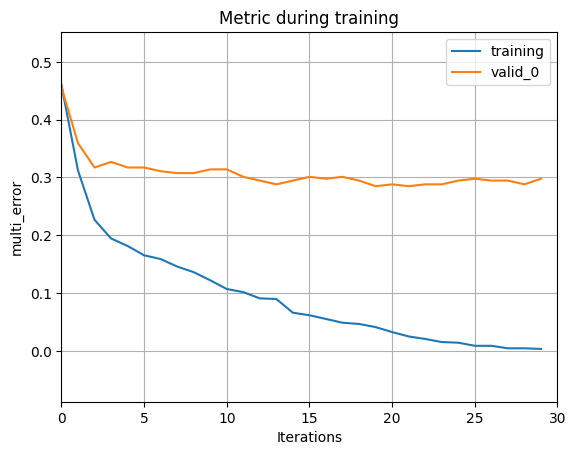

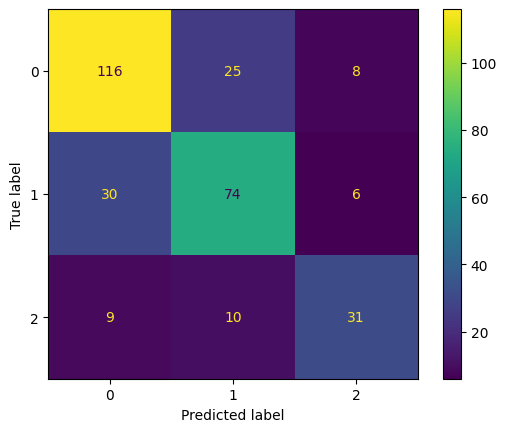

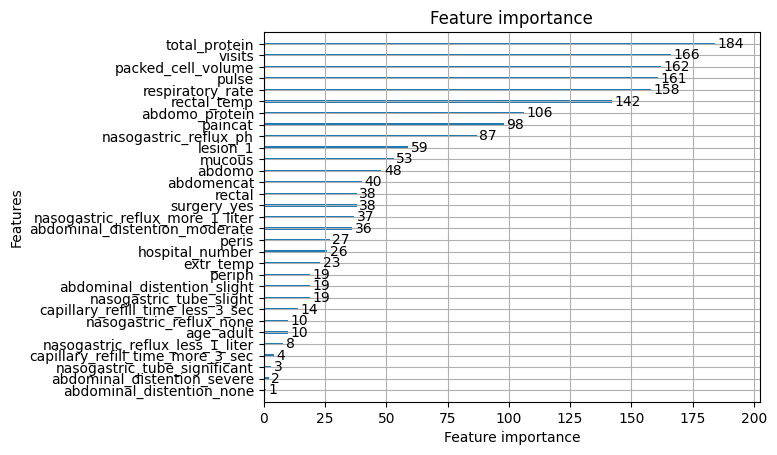

In [33]:
print('Training accuracy {:.4f}'.format(lgb_model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgb_model.score(val_X, val_y)))

lgb.plot_metric(lgb_model, metric='multi_error')
ConfusionMatrixDisplay.from_estimator(lgb_model,val_X,val_y)
lgb.plot_importance(lgb_model)

In [34]:
toxiccols = []
# Create model with full data for submission
lgb_model = lgb.LGBMClassifier(learning_rate=0.03,
                               max_depth=-5,
                               random_state=1,
                               n_estimators=60)
lgb_model.fit(X_train.drop(toxiccols,axis=1,inplace=False),y_train)

# make predictions
lgbpredictions = lgb_model.predict(x_test.drop(toxiccols,axis=1,inplace=False))

In [35]:
# convert categoricals to string foor submission
pred_labeled_lgb=[]
for y in lgbpredictions:
    pred_labeled_lgb.append(cat_to_lde(y))

In [36]:
output = pd.DataFrame({'id':test_data['id'],
                      'outcome':pred_labeled_lgb })
output.to_csv('submission.csv',index=False)

In [37]:
# Create a dataframe with all predictions
ensemble = pd.DataFrame({'xgb':pred_labeled_xgb, 
                         'rf':pred_labeled_rf, 
                         'lgb':pred_labeled_lgb})

#use the mode of each prediction for ensemble submission
ensemble_prediction = []
for ind,row in ensemble.iterrows():
    ensemble_prediction.append(st.mode(row))

In [38]:

output = pd.DataFrame({'id':test_data['id'],
                      'outcome':ensemble_prediction })
output.to_csv('submission_x.csv',index=False)